In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Own implementations
%load_ext autoreload
%autoreload 2
from data_generation import *
from linear_model import *
from stochastic_gradient_descent import * 
from transformation import *
from pipeline import Pipeline
from metric import *
from model_selection import *

In [3]:
# Misc
import sys
sys.path.insert(0, '../misc')
import plots

In [13]:
data = load_breast_cancer()
X = data.data
y = data.target

#Is there a way to get the train test split used in the StochasticGradientDescent class?
train_ids = np.sort(np.random.choice(len(X),size=450,replace=False))
X_train, y_train = X[train_ids], y[train_ids]
X_test  = X[np.sort(np.setdiff1d(np.arange(0,len(X)),train_ids))]
y_test = y[np.sort(np.setdiff1d(np.arange(0,len(X)),train_ids))]

scaler = Standardization()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
#%% Extract the features present in the Data with PCA
from sklearn.decomposition import PCA

features_cor = np.corrcoef(data.data.T)
features_PCA = PCA().fit(data.data)
features_decomp = PCA().fit_transform(data.data)
exp_var = features_PCA.explained_variance_ratio_


/tmp/ipykernel_16649/3920749384.py:18: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


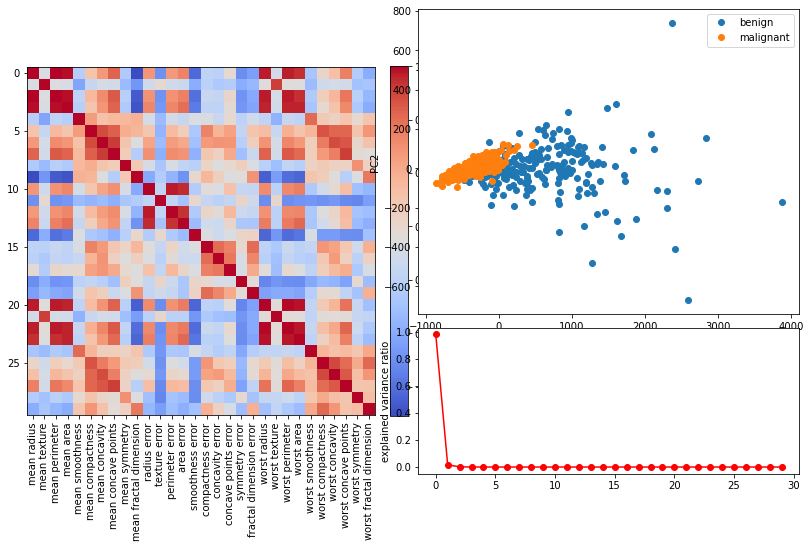

In [15]:
fig_size = plots.set_size(1000)
fig = plt.figure(figsize=fig_size)
gs = gridspec.GridSpec(6,12)
ax_1 = plt.subplot(gs[:6,:6])
ax1=ax_1.imshow(features_cor,cmap='coolwarm')
plt.xticks(np.arange(0,len(features_cor)),labels=data.feature_names,rotation=90)
plt.colorbar(ax1,fraction=0.046,pad=0.04)
ax_2 = plt.subplot(gs[:4,6:])
ax_2.plot(features_decomp[y==0,0],features_decomp[y==0,1],'o')
ax_2.plot(features_decomp[y==1,0],features_decomp[y==1,1],'o')
ax_2.legend(['benign','malignant'])
ax_2.set_xlabel('PC1')
ax_2.set_ylabel('PC2')
ax_3 = plt.subplot(gs[4:,6:])
ax_3.plot(exp_var,'r-o')
# ax_3.set_xlabel('PC #')
ax_3.set_ylabel('explained variance ratio')
plt.tight_layout()

In [23]:
#%% Sklearn implementation vs Support Vector Machines vs 
#our implementation across learning rates and regularization values

#set pca_reduction to an integer corresponding to the number of principal features
#to do classification with. 0 leads to the use of the original features
pca_reduction = 0
if pca_reduction>0:        
    X_train = features_decomp[train_ids,:pca_reduction]
    X_test = features_decomp[np.sort(np.setdiff1d(np.arange(0,len(X)),train_ids)),:pca_reduction]
lrs = np.logspace(-6,0,7)
penalties = np.logspace(-9,0,10)
success_rate_ours = np.zeros([len(penalties),len(lrs)])
success_rate_sklearn = np.zeros([len(penalties),len(lrs)])
success_rate_svm = np.zeros([len(penalties)])
count = 0

for p in range(len(penalties)):
    Classifier_SVC = SVC(C=1/penalties[p])
    fit_svc = Classifier_SVC.fit(X_train,y_train)
    for l in range(len(lrs)):
        
        Classifier_sklearn = SGDClassifier(loss='log',
                                           penalty='l2',
                                           alpha=penalties[p],
                                           learning_rate='constant',
                                           eta0=lrs[l],
                                           early_stopping=False,
                                           random_state=42,
                                           tol = 1e-3
                                          )
        
        Classifier_ours = LogisticRegression(penalty=penalties[p]/2,
                                                 batches=X_train.shape[0], 
                                                 learning_rate=Constant(eta0=lrs[l]),
                                                 early_stopping=False,
                                                 seed=42,
                                                 tol=1e-3 * X_train.shape[0],
                                                 verbose=False
                                            )
        
        Classifier_ours.fit(X_train,y_train)
        Classifier_sklearn.fit(X_train,y_train)

        classified = Classifier_ours.predict(X_test)
        success_rate_ours[p,l] = np.sum(classified==y_test)/len(y_test)
        success_rate_sklearn[p,l] = Classifier_sklearn.score(X_test,y_test)
    success_rate_svm[p] = Classifier_SVC.score(X_test,y_test)
success_rate_svm = np.expand_dims(success_rate_svm,1)    

/Users/timzimmermann/Documents/PhD/courses/compsci/projects/01_regression_resampling/src/linear_model.py:134: RuntimeWarning: overflow encountered in matmul
  y_y_prop = y - expit(p[0] + X @ p[1:])
/Users/timzimmermann/Documents/PhD/courses/compsci/projects/01_regression_resampling/src/stochastic_gradient_descent.py:159: RuntimeWarning: overflow encountered in subtract
  p -= (


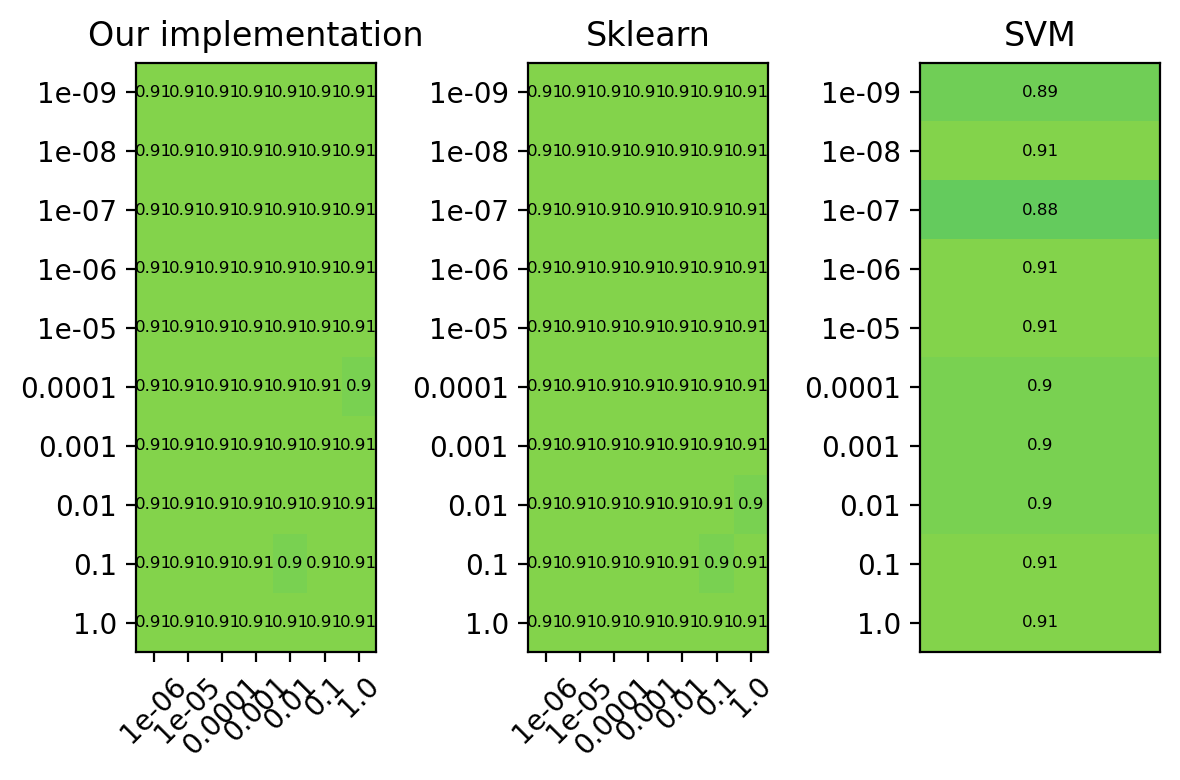

In [24]:
#%%Plot of the performance of different methods
plt.figure(dpi=200)
plt.subplot(1,3,1)

plots.annotate_imshow(success_rate_ours,vmin=0.5)
plt.xticks(np.arange(0,len(lrs)),lrs,rotation=45)
plt.yticks(np.arange(0,len(penalties)),penalties)
plt.title('Our implementation')

plt.subplot(1,3,2)
plots.annotate_imshow(success_rate_sklearn,vmin=0.5)
plt.xticks(np.arange(0,len(lrs)),lrs,rotation=45)
plt.yticks(np.arange(0,len(penalties)),penalties)
plt.title('Sklearn')
plt.subplot(1,3,3)
plots.annotate_imshow(success_rate_svm,vmin=0.5)
plt.yticks(np.arange(0,len(penalties)),penalties)
plt.xticks([])
plt.title('SVM')
plt.tight_layout()